In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  # Outlier:

In [2]:
classes = ['CEP',
           'DSCT',
           'E',
           'RRL',
           'LPV',
           'SLSN',
           'SNII',
           'SNIa',
           'SNIbc',
           'AGN',
           'Blazar',
           'CV/Nova',
           'QSO',
           'YSO']

outlier_index=13
outlier = classes[outlier_index]

### reading the training set files 

In [3]:
unlabeled_dataset = pd.read_csv('data/unlabeled_dataset.csv')
train_set = pd.read_pickle('data/train_data_not_filtered.pkl').fillna(-999)
test_set = pd.read_pickle('data/test_data_not_filtered.pkl').fillna(-999)

In [4]:
features = pd.read_pickle('features_RF_model.pkl')

In [5]:
train_set = train_set[(train_set['classALeRCE']!=outlier)]
test_set = test_set[(test_set['classALeRCE']!=outlier)]


print(np.unique(train_set.classALeRCE))

['AGN' 'Blazar' 'CEP' 'CV/Nova' 'DSCT' 'E' 'LPV' 'QSO' 'RRL' 'SLSN' 'SNII'
 'SNIa' 'SNIbc']


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    #plt.close()

### Pre-processing training data

In [7]:
#splitting training set
X_train_hierarchical, X_test_hierarchical = train_set[features], test_set[features]
y_train_hierarchical, y_test_hierarchical = train_set['hierClass'], test_set['hierClass']
y_train_original, y_test_original = train_set['classALeRCE'], test_set['classALeRCE']


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

72573 23972 1418


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9886814276272307
Balanced accuracy: 0.9878963203354996


[[17831   100    12]
 [  134  5752    27]
 [    0     1   351]]
Normalized confusion matrix
[[ 99.   1.   0.]
 [  2.  97.   0.]
 [  0.   0. 100.]]


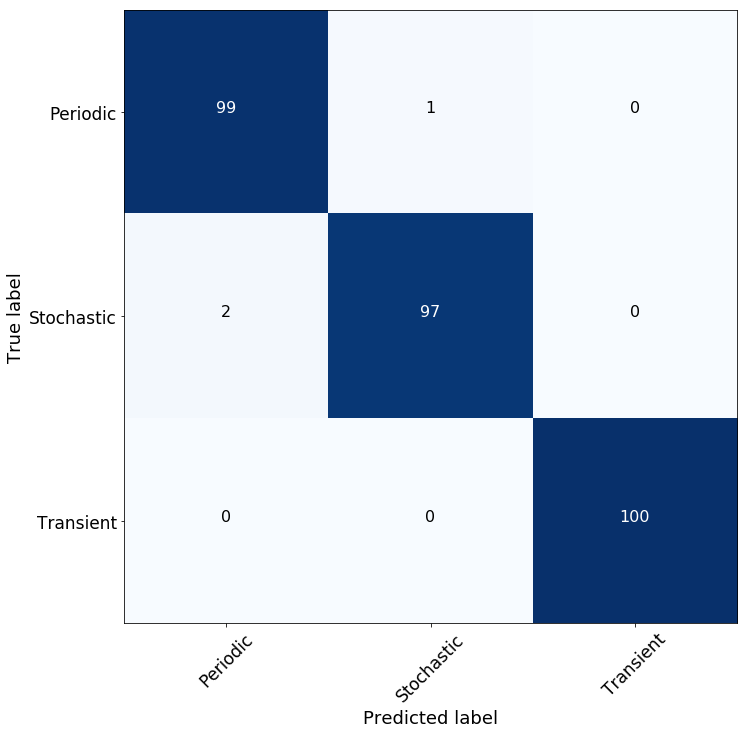

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=classes_order_proba_hierarchical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes_order_proba_hierarchical)

  ### Periodic layer

In [10]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

['CEP' 'DSCT' 'E' 'LPV' 'RRL']


  ### Stochastic layer

In [11]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

['AGN' 'Blazar' 'CV/Nova' 'QSO']


  ### Transient layer

In [12]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)


['SLSN' 'SNII' 'SNIa' 'SNIbc']


## Putting all together

In [13]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 6.851666802337852e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP' 'DSCT'
 'E' 'LPV' 'RRL']


[[ 182   59   16    4    0    0    0    1    0    0    0    0    0]
 [   6   13    0    0    0    0    0    0    0    0    0    0    0]
 [   8   13   36    9    0    1    0    0    0    0    0    0    0]
 [   0    0    1    3    0    0    0    0    0    0    0    0    0]
 [   0    0    0    1 3988  334  218    4    3    4    1    2    0]
 [   0    0    0    0   90  742   56    2   11    4    0    1    1]
 [   0    0    0    0   47   38  163    5    7    0    0    0    4]
 [   7    5    1    0    0    0    2  127    3    5    8   24    5]
 [   1    1    0    0    2    7    4    0 2844    1    1    0   34]
 [   0    0    0    0   22    0   14   47    8 6838  542  268  402]
 [   0    0    0    0    0    0    0    1    1   12  132    3    4]
 [   1    1    0    0   30    0    7   15    3  425  236 5800  110]
 [   0    0    0    0    0    0    0    0    5    6    1   13  101]]
Normalized confusion matrix
[[69. 23.  6.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [32. 68.  0.  0.  0.  0.  0.  0

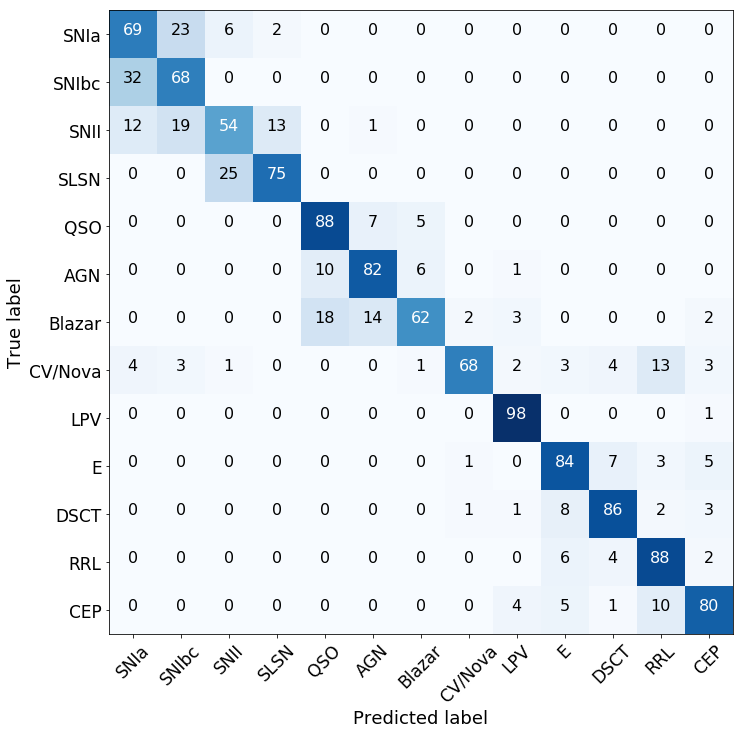

In [14]:
# generating confusion matrix for multilabels

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP']
label_order.remove(outlier)

cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order)

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))

print(metrics.classification_report(y_test_original, class_final_name, digits=2))

# Predicting on unlabeled data

In [15]:
unlabeled_dataset = unlabeled_dataset.drop(['Periodic', 'Stochastic', 'Transient', 'Unnamed: 0',], axis=1)
unlabeled_columns = list(unlabeled_dataset)
unlabeled_dataset = pd.concat([unlabeled_dataset, train_set.reset_index()[unlabeled_columns], test_set.reset_index()[unlabeled_columns]])

In [16]:
X = unlabeled_dataset.set_index('oid')[features].astype('float32').copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(-999)

In [17]:
#predicting classes of unlabeled data

test_Y_hierarchical = rf_model_hierarchical.predict(X)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(X)

test_Y_periodic = rf_model_periodic.predict(X)
test_Y_proba_periodic = rf_model_periodic.predict_proba(X)

test_Y_stochastic = rf_model_stochastic.predict(X)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(X)

test_Y_transient = rf_model_transient.predict(X)
test_Y_proba_transient = rf_model_transient.predict_proba(X)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]

[1. 1. 1. ... 1. 1. 1.] 1.0 7.450689151903706e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP' 'DSCT'
 'E' 'LPV' 'RRL']


In [18]:
prob_final_ul.shape

(559656, 13)

In [19]:
unlabeled_dataset.shape

(559656, 205)

In [20]:
#Writing results in the output
print(unlabeled_dataset.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


unlabeled_dataset['predicted_class'] = class_final_name_ul
unlabeled_dataset['predicted_class_proba'] = class_final_proba_ul

probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=unlabeled_dataset.oid)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=unlabeled_dataset.oid)

(559656, 205)
559656
559656


In [21]:
unlabeled_dataset_preds = pd.concat([unlabeled_dataset.set_index('oid'), prob_pd_ul, prob_h_pd_ul], axis=1)

In [22]:
unlabeled_dataset_preds.replace(-999, np.nan, inplace=True)

In [23]:
unlabeled_dataset_preds['hierClass'] = test_Y_hierarchical

In [24]:
unlabeled_dataset_preds = unlabeled_dataset_preds[(unlabeled_dataset_preds['n_det_1']>=6) & (unlabeled_dataset_preds['n_det_2']>=6)]
unlabeled_dataset_preds = unlabeled_dataset_preds[((unlabeled_dataset_preds.hierClass=='Transient') & (unlabeled_dataset_preds.flag_reference_change==False) & (unlabeled_dataset_preds.flag_diffpos==True)) | ((unlabeled_dataset_preds.hierClass=='Periodic') & (unlabeled_dataset_preds.flag_corrected_g==True) & (unlabeled_dataset_preds.flag_corrected_r==True)& (unlabeled_dataset_preds.flag_ndubious_g<1) & (unlabeled_dataset_preds.flag_ndubious_r<1)) | ((unlabeled_dataset_preds.hierClass=='Stochastic') & (unlabeled_dataset_preds.flag_corrected_g==True) & (unlabeled_dataset_preds.flag_corrected_r==True)& (unlabeled_dataset_preds.flag_ndubious_g<1) & (unlabeled_dataset_preds.flag_ndubious_r<1))]

In [25]:
unlabeled_dataset_preds.shape

(394041, 223)

In [26]:
unlabeled_dataset_preds.to_pickle('data/kd_train_data_without_{}.pkl'.format(outlier))



In [27]:
unlabeled_dataset_preds.head()

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,SNIbc_prob,CEP_prob,DSCT_prob,E_prob,LPV_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient,hierClass
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaafbp,0.145461,0.067991,0.990215,0.342668,1.0,1.0,0.294118,0.285714,0.0,0.0,...,0.003432,0.039864,0.090600,0.684936,0.003624,0.086976,0.906,0.082,0.012,Periodic
ZTF17aaaappe,0.171415,0.201020,1.000000,1.000000,1.0,1.0,0.200000,0.457627,0.0,0.0,...,0.001176,0.057188,0.084796,0.642872,0.000000,0.201144,0.986,0.008,0.006,Periodic
ZTF17aaabbkl,0.277655,0.176079,0.880929,0.825180,1.0,1.0,0.380952,0.347826,0.0,0.0,...,0.002256,0.289408,0.055216,0.466480,0.017136,0.123760,0.952,0.040,0.008,Periodic
ZTF17aaabcqo,0.236008,0.175954,1.000000,1.000000,3.0,9.0,0.350000,0.489796,0.0,0.0,...,0.008364,0.199076,0.045648,0.213024,0.102708,0.073544,0.634,0.332,0.034,Periodic
ZTF17aaabeke,0.425834,0.416041,1.000000,1.000000,1.0,1.0,0.381356,0.338843,0.0,0.0,...,0.000000,0.086000,0.044000,0.802000,0.004000,0.064000,1.000,0.000,0.000,Periodic
